<a href="https://colab.research.google.com/github/paulodowd/GoogleColab_Simple2DSimulator/blob/main/Sheet4_SensorNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sheet 4: Sensor Noise

**Before you start**, you should have previously worked through **Sheet 1, Sheet 2 and Sheet 3**.  This will mean you are familiar with how we are writing controllers for a simulated robot.  In this exercise sheet, we are going to write code so that our robot can follow another robot.  However in this exercise sheet, we are first of all going to update how the simulated sensors work so that they are a better approximation of a real sensor.  This will make this quite a difficult exercise sheet to complete!

<p align="center">
<img src="https://github.com/paulodowd/GoogleColab_Simple2DSimulator/blob/main/img/Following.png?raw=true" width="30%">
</p>





## The Simulated Sensor

Our 2D Simulation uses a very simple model of a sensor.  If we take a closer look at the `ProxSensor_c` class, we see the following code storing **distance** as the **sensor reading**:

```python
    ...

    # If the current reading is -1 then that means
    # this is the first valid reading, and we update
    # the sensor.
    if self.reading < 0:
      self.reading = distance

    # If the sensor already has a valid reading (>-1)
    # then we only store the new reading if it is closer.
    # (closer obstructions block the field of view)
    if self.reading > 0:
      if distance < self.reading:
        self.reading = distance

    ...
```

We can also find within the `ProxSensor_c` class the following line of code, where the <a href="https://en.wikipedia.org/wiki/Euclidean_distance#:~:text=In%20mathematics%2C%20the%20Euclidean%20distance,being%20called%20the%20Pythagorean%20distance.">euclidean distance</a> from the robot to the obstruction is calculated:

```python
    # See if the obstruction is within the detection
    # range of the sensor.
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
```

This means that our simulated sensor reading is the exact distance between the sensor and the obstruction.  If we were to produce a graph of the way the simulated sensor currently responds, it would look like:

<p align="center">
<img src="https://github.com/paulodowd/GoogleColab_Simple2DSimulator/blob/main/images/sim_sensor_response.png?raw=true">
</p>





## Pololu SDS020 Proximity Sensor

<p align="center">
<img src="https://a.pololu-files.com/picture/0J5782.600x480.jpg?d0dc29ca33bde495d7507411e2fa3a8d" width="25%">
</p>

The above is the Pololu SDS02A Proximity Sensor (<a href="https://www.pololu.com/product/2476">product page</a>).  The sensor transmits a beam of infra-red light and senses the reflection to estimate distance.  This means we can use the sensor to detect obstructions.

We can view the official datasheet (<a href="https://www.pololu.com/file/0J812/gp2y0a60szxf_e.pdf">here</a>) for this sensor and find the following graph.  This graph shows how the voltage of the sensor varies with respect to it's distance to an object:

<p align="center">
<img src="https://github.com/paulodowd/GoogleColab_Simple2DSimulator/blob/main/images/sds02a_response.png?raw=true" width="75%">
</p>

First of all, **this looks very different to our current simulated response!**

We can read the above graph as:
 > "sensor output voltage decreases non-linearly with respect to an increasing distance"

Some things to immediately notice are that:
- the sensor output is a voltage, not a unit of distance.
  - with a real robot, we might have to use an analog-to-digital converter (see, <a href="https://learn.sparkfun.com/tutorials/analog-to-digital-conversion/all">SparkFun</a>, <a href="https://en.wikipedia.org/wiki/Analog-to-digital_converter">Wikipedia</a>) to record the sensor output into computer memory.
- the response is not linear, meaning the amount the voltage varies with respect to distance is not constant.
- the data has been captured against white paper, which means we should expect it to vary against other surfaces and conditions.
- the graph doesn't tell us what happens at values less than 10cm, or greater than 150cm.



## Informing a Simple Model

We will now quickly review how this exercise sheet implements simple model of the SDS02a sensor.  The below code cell imports real data captured from the SDS02a sensor.  The sensor was set to make a distance measurement across a range of 0 to 25cm:


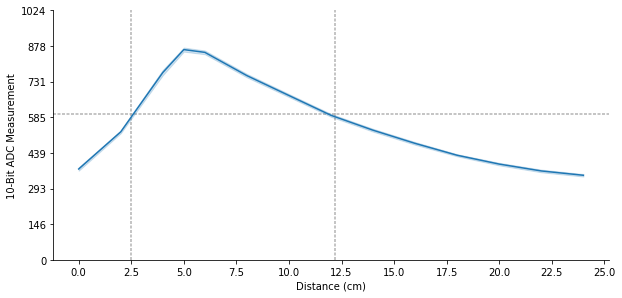

In [106]:

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# This reads a CSV file from Github which contains 
Data=pd.read_csv('https://raw.githubusercontent.com/paulodowd/GoogleColab_Simple2DSimulator/main/data/prox_data.csv')
g=sns.relplot(x="Distance", y="Raw", kind="line", ci="sd", data=Data,height=4, aspect=2.1)
g.map(plt.axhline, y=600, color=".7", dashes=(2, 1), zorder=0)
g.map(plt.axvline, x=2.5, color=".7", dashes=(2, 1), zorder=0)
g.map(plt.axvline, x=12.2, color=".7", dashes=(2, 1), zorder=0)
g.set_axis_labels("Distance (cm)", "10-Bit ADC Measurement")
g.set(yticks=np.linspace( 0, 1024, 8))
g.set(xticks=np.linspace( 0, 25, 11))

### Perceptual Aliasing

In the above graph we can see the non-linear **sensor response curve**, similar to what was presented in the datasheet.  The y-axis has been left in the 10-bit resolution [0:1023] analog-to-digital measurement, which corresponds to 0-5volts.

In the above graph we can see a peak at approximately 5cm.  We can see that below 5cm, the measurement reading decreases, in a similar way to how the signal decreases after 5cm.  This is a difficult problem for our robot.  

Grey dashed lines have been used to indicate regions for discussion.  Where the grey dashed lines cross we can observe that:
- The 10-bit ADC measurement is equal at positions 2.5cm and 12.2cm
- This means the robot cannot know from a single reading if it is at 2.5cm or 12.2cm from an object.
- We can see this phenomenon would repeat at all values less that 5cm.
- This is called **Perceptual Aliasing**
- How could we avoid perceptual aliasing with a robot?  This is one the key challenges of this exercise sheet!

After 25cm, the sensor cannot discriminate any further distances.  More importantly, after 25cm (to infinity), the sensor simply reports an average nominal value with some noise.  This means that after 25cm, the sensor responds as if there were objects at 25cm even when there are not :(  









### Sensitivity

The non-linear response of the sensor is also a difficult element for our robot.  In the portion of the graph after 12.2cm, we can see that the gradient of the line is shallow - between 22.5cm and 25cm it begins to get very flat!  This means that there is less change in the measurement for every centimeter, compared to the signal prior to 12.2cm.  We can generally understand this to mean that **the sensor becomes less sensitive as distance increases**.  The steeper the line gradient, the more sensitive a sensor is.



### Noise

In this next section, we have taken an equation for trendline for the above plot, and used this convert the readings into a linear measurement of distance in cm.  The has the effect of "flipping" the graph over, because we are no longer looking a decreasing voltage with respect to distance.

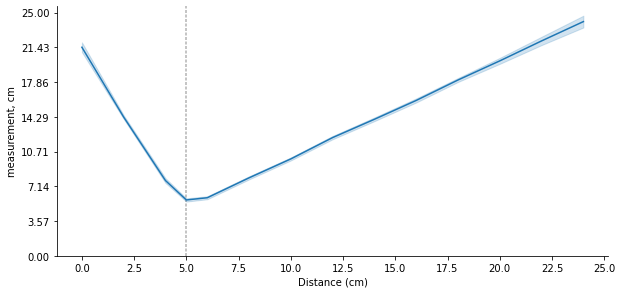

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# This reads a CSV file from Github which contains 
Data=pd.read_csv('https://raw.githubusercontent.com/paulodowd/GoogleColab_Simple2DSimulator/main/data/prox_data.csv')
g=sns.relplot(x="Distance", y="Linear", kind="line", ci="sd", data=Data,height=4, aspect=2.1)
g.map(plt.axvline, x=5, color=".7", dashes=(2, 1), zorder=0)
g.set_axis_labels("Distance (cm)", "measurement, cm")
g.set(yticks=np.linspace( 0, 25, 8))
g.set(xticks=np.linspace( 0, 25, 11))

In the above graph, the raw 10-bit ADC sensor measurement has been processed into cm on the y-axis.  Now when the sensor measures beyond 5cm on the x-axis (indicated as a dashed line), the signal is linear. This is closer to our initial simulated sensor (if you remember, this was a straight line, a linear relationship between actual distance and measured distance). 

However, you can notice that there is a blue region around the plotted line that grows in width with distance along the x-axis.  This is the error as standard deviation as recorded within the data.  This observation correlates to a decreasing sensitivity with distance made in the previous section.  As sensitivity decreases, error increases.

We can plot the the error as standard deviation against the actual distance of the sensor from an obstruction:


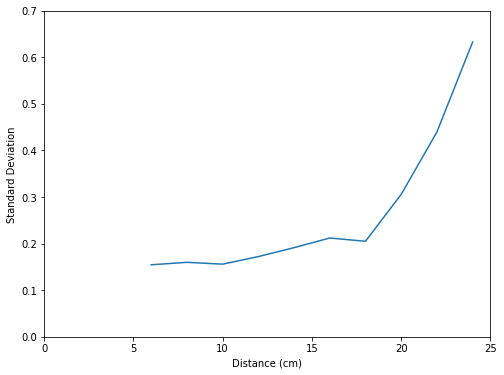

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# This reads a CSV file from Github which contains 
Data=pd.read_csv('https://raw.githubusercontent.com/paulodowd/GoogleColab_Simple2DSimulator/main/data/prox_processed.csv')
x_d =  Data.loc[:, 'Distance']
y_sd = Data.loc[:, 'StdDev']

# plot how the standard deviation varies
fig = plt.figure(figsize=(8,6))
plt.plot(x_d,y_sd)
plt.ylabel('Standard Deviation')
plt.xlabel('Distance (cm)')
plt.xlim(0,25)
plt.ylim(0,0.7)
plt.show()

In the above graph, we can clearly see how the error in the sensor readings increases with distance.  This means that if we were to take a reading at a known value of 20cm distance from an object, we would expect the sensor to report a value that deviates from 20cm within a probable range - as per the graph above.  It is interesting to consider across probability distribution this error occurs. For our simulation, we will use the <a href="https://en.wikipedia.org/wiki/Normal_distribution">normal distribution (or Gaussian distribution)</a>.  

If we plot a gaussian distribution using the standard deviation of different distances measurements, we can clearly see how the noise is likely to effect the sensor:

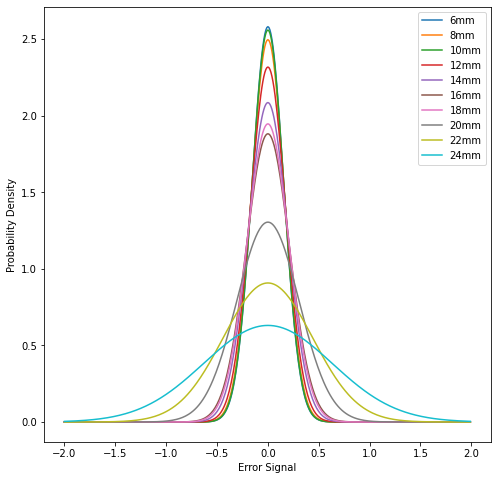

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# This reads a CSV file from Github which contains 
Data=pd.read_csv('https://raw.githubusercontent.com/paulodowd/GoogleColab_Simple2DSimulator/main/data/prox_processed.csv')
x_d =  Data.loc[:, 'Distance']
y_sd = Data.loc[:, 'StdDev']

# Set up the x axis range.  You might need to adjust this
# if you explore other parameters in this worksheet.  
x = np.arange(-2,2,.01)

# equation for a gaussian distribution function.
#f = 1/(np.sqrt(2*np.pi)* sd ) * np.exp( -np.power((x - mean)/ sd, 2)/2)

sd = np.asarray(y_sd)
f6 = 1 / (np.sqrt( 2 * np.pi)* sd[0]) * np.exp( -np.power(x/sd[0],2)/2)
f8 = 1 / (np.sqrt( 2 * np.pi)* sd[1]) * np.exp( -np.power(x/sd[1],2)/2)
f10 = 1 / (np.sqrt( 2 * np.pi)* sd[2]) * np.exp( -np.power(x/sd[2],2)/2)
f12 = 1 / (np.sqrt( 2 * np.pi)* sd[3]) * np.exp( -np.power(x/sd[3],2)/2)
f14 = 1 / (np.sqrt( 2 * np.pi)* sd[4]) * np.exp( -np.power(x/sd[4],2)/2)
f16 = 1 / (np.sqrt( 2 * np.pi)* sd[5]) * np.exp( -np.power(x/sd[5],2)/2)
f18 = 1 / (np.sqrt( 2 * np.pi)* sd[6]) * np.exp( -np.power(x/sd[6],2)/2)
f20 = 1 / (np.sqrt( 2 * np.pi)* sd[7]) * np.exp( -np.power(x/sd[7],2)/2)
f22 = 1 / (np.sqrt( 2 * np.pi)* sd[8]) * np.exp( -np.power(x/sd[8],2)/2)
f24 = 1 / (np.sqrt( 2 * np.pi)* sd[9]) * np.exp( -np.power(x/sd[9],2)/2)

fig = plt.figure(figsize=(8,8))

# Produce the plot!
plt.plot(x,f6, x, f8, x, f10, x, f12, x, f14, x, f16, x, f18, x, f20, x, f22, x, f24 )
plt.legend(['6mm', '8mm', '10mm', '12mm', '14mm', '16mm', '18mm', '20mm', '22mm', '24mm'])
plt.xlabel('Error Signal')
plt.ylabel('Probability Density')
plt.show()

The above graph indicates a quantity of **error** we would expect to add to our sensor reading, with probability indicated by the shape of the curve.  For instance, in all cases, there is a peak to the curve centred on 0, meaning that often there is no error (i.e. an addition of error=0 has a high probability).  We can also observe that the error could be positive or negative, adding or subtracting from the sensor measurement respectively.  

We can make the following observations from the above graph.  The plot for 24mm shows a low and relatively flat bell shape.  This means that there is a strong likelihood for the error to be a value away from 0, and can take a magnitude towards +/-2cm.  Meanwhile, the plot for 8mm has a very tall and slim curve centered on 0, meaning that there is a high likelihood that the error will be close to 0, and it is unlikely it will exceed 0.5cm at its worst.  

## Updating our Simulator

From the above short analysis, we want to make the following modifications to our simulated sensor:
1. The sensor should report a maximum distance of 20cm even when there is no obstruction to the sensor.
2. The sensor should "malfunction" for values less than a minimum of 5cm, reporting an increasing distance measurement for decreasing distances. 
3. The sensor should include the addition of error with respect to the distance being measured.

All these changes will be made into the  `ProxSensor_c` class below, and the changes are documented here for your review.  To make this easier, all the changes have been placed within a function called `postProcess()`:

### 1. Maximum Distance

### 2. Minimum Distance

### 3. Error

# Preliminary Code

The following cells contain the code for the elements inside the simulator.  You can read these if you wish.  **It is requested that you do not edit any of these cells yet.**  You will come back in later worksheets to improve these.

## Proximity Sensors

The below is a simple model and functions for a proximity sensor.  We will develop this sensor further in the next couple of worksheets.  Click to compile before proceeding.

In [125]:
from math import *
import numpy as np


#
# The model of the proximity sensor.
#
#
class ProxSensor_c:
  
  # current global xy position of sensor
  x = 0
  y = 0
  theta = 0
  
  # To store the last sensor reading
  reading = 0

  # To set sensor local position around the robot body.
  offset_dist = 0
  offset_angl = 0

  # maximum scan range:
  max_range = 20

  # constructor. by default, sensor sits 10 distance forward
  # and faces 0 radians with respect to robot origin (0,0).
  def __init__(self, offset_dist=5, offset_angl=0):
    self.offset_dist = offset_dist
    self.offset_angl = offset_angl


  def updateGlobalPosition(self, robot_x, robot_y, robot_theta ):

    # Current direction of the sensor is the rotation
    # of the robot body plus the fixed rotation of the 
    # sensor around that same body.
    self.theta = self.offset_angl + robot_theta

    # With the rotation, we now work out where the 
    # sensor sits in cartesian space (x,y) by projecting
    # out by offset_distance.
    # Note, we do this as if the sensor was at origin (0,0)
    sensor_x = (self.offset_dist*np.cos(self.theta))
    sensor_y = (self.offset_dist*np.sin(self.theta))

    # commit new position to memory, translating to the 
    # robots current x,y position.
    self.x = sensor_x + robot_x
    self.y = sensor_y + robot_y

    # If we've reset position, the last sensor reading
    # is now wrong.  
    self.reading = -1

  def scanFor( self, obstruction ):

    # See if the obstruction is within the detection
    # range of the sensor.
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
    distance = distance - obstruction.radius

    # if out of range, return error
    # note: real sensors aren't this easy.
    if distance > self.max_range:
      return

    # compute this sensors angle toward the obstruction
    # (e.g. where is the object relative to the sensor?)
    a2o = atan2( ( obstruction.y - self.y), (obstruction.x-self.x ))

    # computer the smallest angle between the line of 
    # sight of the sensor, and the current angle to the
    # obstruction.
    # [insert url here]
    angle_between = atan2( sin(self.theta-a2o),  cos(self.theta-a2o) )
    angle_between = abs( angle_between )
    
    # If the detection is outside of the field of view
    # of the sensor, then we return and do nothing else.
    # This will either leave the reading as -1 (invalid)
    # for the next call.  Or leave the reading as the
    # last valid reading (>-1) it had.
    if angle_between > np.pi/8:
      return

    # If the current reading is -1 then that means
    # this is the first valid reading, and we update
    # the sensor.
    if self.reading < 0:
      self.reading = distance

    # If the sensor already has a valid reading (>-1)
    # then we only store the new reading if it is closer.
    # (closer obstructions block the field of view)
    if self.reading > 0:
      if distance < self.reading:
        self.reading = distance

  def postProcess(self):
    # Maximum Distance
    # The sensor stores -1 for a reading which was either
    # inside the robot (collision) or out of range.
    # Therefore, if we have -1, we set the reading to 
    # the maximum distance reading (max_range). Error will
    # be added later. 
    if self.reading < 0:
      self.reading = self.max_range
    
    # Minimal Distance
    # From 5cm down to 0cm, as the actual distance decreases
    # the measurement increases towards 20cm.
    # First, we convert the reading to a normalised range
    # 0:1 (between 0:5cm)
    # Then, we linearly interpolate an inverse
    # relationship ( 0:1 -> 20:5 )
    elif self.reading < 5.0:
      d_min = 5.0
      d_max = 20.0
      
      scalar = ( (d_min - self.reading) / 5.0)
      self.reading = d_min + ( (d_max - d_min) * scalar )


    # General Error: 
    # We add some error depending on the distance recorded.  For 
    # simplicity, we will make a linear interpolation of
    # standard deviation between 0.15 and 0.6, which is what
    # we graphed earlier.
    sd_min = 0.15
    sd_max = 0.6
    # normalise reading 0:1 within max_range to get a scalar value
    scalar = (self.reading/self.max_range)
    # use this 0:1 value to scale the standard deviation
    sd = sd_min + ( (sd_max - sd_min)*scalar)
    error = np.random.normal(0,sd)
    self.reading = self.reading + error 
      
    
    



## The Robot

The below is a simple model of a robot, which includes the proximity sensor above.  Click to compile before proceeding.

In [126]:

from math import *
import numpy as np

#
# The model of the robot.
#
#
class Robot_c:
  
  # We could do something like, manually add 2 sensors  
  #prox_sensors.append( ProxSensor_c(2, np.pi/8) )
  #prox_sensors.append( ProxSensor_c(2, -np.pi/8) )

  def __init__(self, x,y,theta):
    self.x = x 
    self.y = y 
    self.theta = theta# theta
    self.stall = -1 # to check for collisions
    self.score = 0
    self.radius = 5 # 5cm radius
    self.wheel_sep = self.radius*2 # wheel on either side
    self.vl = 0
    self.vr = 0
    
    # This is the body plan of sensors from
    # an e-puck robot! (in radians)
    self.sensor_dirs = [0.296706,
                        0.8726646, 
                        1.570796,
                        2.617994, 
                        3.665191, 
                        4.712389,
                        5.410521, 
                        5.986479]

    self.prox_sensors = [] #= ProxSensor_c()
    for i in range(0,8):
      self.prox_sensors.append( ProxSensor_c(self.radius, self.sensor_dirs[i]) )


  def updatePosition( self, vl, vr ):

    if vl > 1.0: 
      vl = 1.0
    if vl < -1.0:
      vl = -1.0
    if vr > 1.0:
      vr = 1.0
    if vr < -1.0:
      vr = -1.0

    # save requested wheel speed for later.
    self.vl = vl
    self.vr = vr

    # clear stall flag, attempt move
    self.stall = -1

    # robot matrix, contributions to motion x,y,theta
    r_matrix = [(vl/2)+(vr/2),0, (vr-vl)/self.wheel_sep]

    # kinematic matrix  
    k_matrix = [
                [ np.cos(self.theta),-np.sin(self.theta),0],
                [ np.sin(self.theta), np.cos(self.theta),0],
                [0,0,1] 
               ]

    result_matrix = np.matmul( k_matrix, r_matrix)

    self.x += result_matrix[0]
    self.y += result_matrix[1]
    self.theta -= result_matrix[2]

    # Once we have updated the robots new global position
    # we should also update the position of its sensor(s)
    for prox_sensor in self.prox_sensors:
      prox_sensor.updateGlobalPosition( self.x, self.y, self.theta )



  # The sensor checks if it is in range to an obstruction,
  # and if yes, calculates the simulated proximity reading.
  # if no, determines and error result.
  def updateSensors(self, obstruction ):

    # for each sensor
    # for each obstruction
    for prox_sensor in self.prox_sensors:
      prox_sensor.scanFor( obstruction ) 

  def postProcessSensors(self):
    for prox_sensor in self.prox_sensors:
      prox_sensor.postProcess()

  def collisionCheck(self, obstruction ):
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
    distance -= self.radius
    distance -= obstruction.radius
    if distance < 0:
      self.stall = 1
      angle = atan2( obstruction.y - self.y, obstruction.x - self.x)
      self.x += distance * np.cos(angle)
      self.y += distance * np.sin(angle)
    
  def updateScore(self):
    
    # 1 minus the difference between wheel speed
    # to encourage straight line travel.  
    # square root rewards small differences
    diff = np.abs(((self.vl+1) - (self.vr + 1))) * 0.5
    
    if diff > 0.0:
      diff =  1 - np.sqrt( diff )
    else:
      diff = 1 # - 0
    
    # Reward motor activation / penalise no movement
    vel = (np.abs(self.vl) + np.abs(self.vr))/2
    
    # Reward sensor activation.
    
    activation = ProxSensor_c.max_range
    for prox_sensor in self.prox_sensors:
      if prox_sensor.reading > -1:
        if prox_sensor.reading < activation:
          activation = prox_sensor.reading

    # normalise the activation between 0:1
    # invert to reward closer readings
    if activation >= 0:
      activation = 1 - (activation / ProxSensor_c.max_range)
    else:
      activation = 0

    new_score = vel * diff * activation

    

    if self.stall == 1:
      new_score -= 3   

    self.score += new_score
      

# Exercise 4.1: Controller for Following Behaviour


The below two cells contain the code for the **controller** and the **simulator**.  It might be useful to first go and run the controller and then run the simulator to see what the output looks like. 

Once you have done this, you can edit the below controller to change the behavior of the robot.  You are welcome to ask for support if something is confusing or you do not understand.

**You should:**
- run the controller cell, and then the simulator cell, and view the output.
- begin to edit the controller to create your own obstacle avoidance behaviour:

  - how should the robot turn behaviour be effected with respect to the distance of a detected obstacle?
  - which sensors are useful?
  - do you need to use all sensors?
  - is there a useful way to process the sensor distance measurement?

**Tips:**
  - In this exercise, there is not a single "correct" solution.  Instead, we are learning to use the simulator by allowing ourselves to *play*.  
  - If it is taking a long time to compile and execute the simulator, and therefore a long time to develop and test your code, you can change the number of simulated seconds to be smaller.  Look for the variable `numframes = 500` and change this to a smaller value.  
  - You can compile all of the code quickly by clicking `Runtime -> Run all`, or `CTRL + F9`.

## The Controller

The below function is the "controller" called by the robot.  The **controller** is the part of the robot software which must decide how the robot should act.  

A robot needs **you** to write some rules, logic, or intelligence in code so the robot will make autonomous decisions.  This is actually very difficult, because we have to imagine all the different circumstances a robot may encounter. We also need to spend some time to understand how variours parts of the robot work.  

In this controller, we need to read the proximity sensors, make a decision, and then set the motor power.  The below class is a minimal template.  You can edit this controller to produce more interesting and intelligent behaviour from your robot. 

Currently, the sensors will report a distance to an object in the range [ 0 : 20 ], 0 being close and 20 being far, and a value of -1 means that no object was detected.

In [90]:
# Not done yet.
#
#  !! This is a test controller and will be removed from the 
#     final Worksheet.
#
#

class Controller_c:

  def __init__ (self):
    self.test = 1

  def update( self, robot ):
    
    vl = 0
    vr = 0

    turn = 0

    # normalise readings [0:1] for 0 to max range
    for prox in robot.prox_sensors:
      prox.reading = (prox.reading / prox.max_range)

    # if prox 0 and 7 are activated (robot in front)
    # then use a weighting against each to create a 
    # turn signal proportional to their difference
  
    s = robot.prox_sensors  # for brevity
    
    m = ((s[0].reading * -1) + (s[7].reading * 1)) / 2

    turn = 0.5 * m

    fwd = ( (s[0].reading - 0.5) + (s[7].reading - 0.5)) / 2
    fwd = 0.2 + (fwd*0.2)


    vl = fwd - turn
    vr = fwd + turn
    
    return vl, vr



## The 2D Simulator

The below code is the Simulator itself, which produces an interactive graph as an output.  Note that, when you run this code pane, it will take some time to execute and to produce the result.  The results is displayed at the bottom as an interactive plot.

In [129]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

# To produce our animated simulation output
from matplotlib import rc
rc('animation', html='jshtml')

# Constants which define the simulator
# We do not need to change these.
numframes = 250
arena_width = 200
num_obstacles = 12
num_sensors = 8


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure(figsize=(8,4), dpi=120)
#fig = plt.figure(dpi=120)
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, arena_width), ylim=(0, arena_width))


# An instance of our simulated Robot!
# Placed in the centre of the arena.
my_robot = Robot_c(50, 100, np.random.normal(0,0.5))
robot2 = Robot_c(70, 100, 0)


gui_robot, = ax.plot([], [], 'bo', ms=my_robot.radius*2)
gui_robot.set_data([], [])
gui_dir, = ax.plot([], [], 'r-', c="yellow")
gui_sensor = ax.plot( *[[],[]]*num_sensors,'r-', c="red")

gui_robot2, = ax.plot([], [], 'o', c="green", ms=robot2.radius*2)
gui_robot2.set_data([], [])
gui_dir2, = ax.plot([], [], 'r-', c="yellow")


#gui_obstacles, = ax.plot([],[],'bo', ms=24, c="orange")
# A list of obstacles within the space
#obstacles = []
#obstacles_xy = []
#for i in range( num_obstacles ):
#  obstacles.append( Obstacle_c( arena_width, 12, i, num_obstacles) )
#  obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )

#obstacles_xy = np.asarray( obstacles_xy, dtype=float)
#gui_obstacles.set_data( obstacles_xy[:,0], obstacles_xy[:,1]  )

# An instance of our controller!
my_controller = Controller_c()


def animate(i):
    
    global ax, fig
    

    # Use controller to set new motor speeds in
    # range [-1.0:+1.0]
    # Note, uses sensor information from prior
    # simulation cycle.
    vl, vr = my_controller.update( my_robot )
    
    # Update robot position, check for collision,
    # then update sensors.
    my_robot.updatePosition(vl, vr)

    # Make robot 2 move randomly
    fwd = 0.3 + np.random.normal(0, 0.4)
    turn = np.random.normal(0,0.4)
    if np.random.uniform(0,1) > 0.75:
      turn += 0.15
    vl = fwd - turn
    vr = fwd + turn
    robot2.updatePosition(vl,vr)


    #for obstacle in obstacles:
    #  my_robot.collisionCheck( obstacle )
    #  my_robot.updateSensors( obstacle )

    my_robot.collisionCheck( robot2 )
    my_robot.updateSensors( robot2 )
    my_robot.postProcessSensors()


    # Draw the robot, change colour for collision
    gui_robot.set_data(my_robot.x, my_robot.y)
    if my_robot.stall == 1:
      gui_robot.set_color("red")
    else:
      gui_robot.set_color("blue")
    
    # Draw a little indicator so we can see which
    # way the robot is facing
    tx = my_robot.x + (my_robot.radius*1.4*np.cos(my_robot.theta))
    ty = my_robot.y + (my_robot.radius*1.4*np.sin(my_robot.theta))
    gui_dir.set_data( (my_robot.x,tx), (my_robot.y, ty) )

    # Draw robot 2
    gui_robot2.set_data(robot2.x, robot2.y)
    tx = robot2.x + (robot2.radius*1.4*np.cos(robot2.theta))
    ty = robot2.y + (robot2.radius*1.4*np.sin(robot2.theta))
    gui_dir2.set_data( (robot2.x,tx), (robot2.y, ty) )
    



    # Draw the sensor beams
    for i in range(8):
      prox_sensor = my_robot.prox_sensors[i]
      ox = prox_sensor.x
      oy = prox_sensor.y
      if prox_sensor.reading > 0:
        tx = prox_sensor.x + prox_sensor.reading * np.cos( prox_sensor.theta)
        ty = prox_sensor.y + prox_sensor.reading * np.sin( prox_sensor.theta)
      else:
        tx = prox_sensor.x + np.cos( prox_sensor.theta)
        ty = prox_sensor.y + np.sin( prox_sensor.theta)

      gui_sensor[i].set_data( (ox,tx), (oy, ty) )
    
    # Update the current score in the title!
    my_robot.updateScore()
    ax.set_title('Score: {0:f}'.format( my_robot.score ))
    
    return gui_robot, 

plt.close()
ani = animation.FuncAnimation(fig, animate, frames=numframes, interval=10, blit=True)
ani


#plt.show()

# Exercise 2.2: Evaluating your Controller

By now you should have a controller for your robot which allows it to successfully navigate without colliding with obstacles.  It can be tricky to get good performance!  

Even when we think we have good performance, usually we do not know how good a solution is until we compare it against something else.  In this case, we can compare our solution against a friend or peer.  

- Talk to someone near you.  How does your score compare to your peers?
- What techniques have your peers used, compared to you?
- With your current controller, create a list of the different scores your robot achieves.
  - Run the simulator 20 times and record the score achieved for each.  You can write the scores into the code cell below.
  - Plot your result scores as a graph.  You can find some help on using matplotlib to make graphs <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/tools_matplotlib.ipynb#scrollTo=KnBYqyxaOLt1">here</a>
  - Exchange your data with a peer, and plot your results against theirs on the same graph.
    - investigate to see if you can render a box-and-whisker plot.
    - who has the better controller?
  - How reliable would you say your controller is?
    - If you ran the simulator 100 times, how many times would your robot crash?
    - What do you think are the primary causes of any variation?



In [92]:
# You can use this code cell to try out code or to 
# plot your own graphs with data you collect.

my_results = [0,0,0,0,0,0]